# Stepping through the theoviel notebook

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%load_ext autoreload
%autoreload 2
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from typing import List, Union, Tuple

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.10.3
transformers.__version__: 4.16.2


In [3]:
class CFG:
    wandb=False
    competition='NBME'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-base"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=5
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=12
    fc_dropout=0.2
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True

These are all operations for computing f1 score on the results

In [4]:
# From https://www.kaggle.com/theoviel/evaluation-metric-folds-baseline

def micro_f1(preds: List[List[int]], truths: List[List[int]]) -> float:
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return f1_score(truths, preds)


def spans_to_binary(spans: List[List[int]], length=None) -> np.ndarray:
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length:int = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
    return binary


def span_micro_f1(preds: List[List[int]], truths: List[List[int]]) -> float:
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
    return micro_f1(bin_preds, bin_truths)

These are functions for taking predictions and mapping them to results which can then be scored

In [5]:
def create_labels_for_scoring(df: pd.DataFrame):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
    return truths


def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results


def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
    return predictions

These are utils for the score, logging, and seeding

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = span_micro_f1(y_true, y_pred)
    return score


def get_logger(filename='train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

I believe these are all the same as the `get_clean_train_data` function that I made. Would be good to have a second pair of eyes verify it.

In [7]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('../data/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)
features = pd.read_csv('../data/features.csv')
def preprocess_features(features):
    features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
    return features
features = preprocess_features(features)
patient_notes = pd.read_csv('../data/patient_notes.csv')

print(f"train.shape: {train.shape}")
print(train.head())
print(f"features.shape: {features.shape}")
print(features.head())
print(f"patient_notes.shape: {patient_notes.shape}")
print(patient_notes.head())

train.shape: (14300, 6)
          id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                               annotation          location  
0          [dad with recent heart attcak]         [696 724]  
1             [mom with "thyroid disease]         [668 693]  
2                        [chest pressure]         [203 217]  
3        [intermittent episodes, episode]  [70 91, 176 183]  
4  [felt as if he were going to pass out]         [222 258]  
features.shape: (143, 3)
   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
2            2         0                                     Chest-p

In [8]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
print(train.head())

          id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                               annotation          location  \
0          [dad with recent heart attcak]         [696 724]   
1             [mom with "thyroid disease]         [668 693]   
2                        [chest pressure]         [203 217]   
3        [intermittent episodes, episode]  [70 91, 176 183]   
4  [felt as if he were going to pass out]         [222 258]   

                                        feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myoc...   
1                 Family-history-of-thyroid-disorder   
2                                     Chest-pressure   
3                              Intermittent-symptoms   
4                                        Lightheaded   

 

In [9]:
# incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

Note:  When they have things like `["a b;c d"]` they are splicing together text from different parts of the sentence

In [10]:
train['annotation_length'] = train['annotation'].apply(len)
print(train['annotation_length'].value_counts())

1    8185
0    4399
2    1292
3     287
4      99
5      27
6       9
7       1
8       1
Name: annotation_length, dtype: int64


This splits the training set into folds. Useful for actual training.

In [11]:
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = train['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['location'], groups)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
print(train.groupby('fold').size())

fold
0    2860
1    2860
2    2860
3    2860
4    2860
dtype: int64


In [12]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained('tokenizer/')
CFG.tokenizer = tokenizer

In [13]:
# ====================================================
# Define max_len
# ====================================================
for text_col in ['pn_history']:
    pn_history_lengths = []
    tk0 = tqdm(patient_notes[text_col].fillna("").values, total=len(patient_notes))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        pn_history_lengths.append(length)
    LOGGER.info(f'{text_col} max(lengths): {max(pn_history_lengths)}')

for text_col in ['feature_text']:
    features_lengths = []
    tk0 = tqdm(features[text_col].fillna("").values, total=len(features))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        features_lengths.append(length)
    LOGGER.info(f'{text_col} max(lengths): {max(features_lengths)}')

CFG.max_len = max(pn_history_lengths) + max(features_lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {CFG.max_len}")

100%|██████████| 42146/42146 [00:29<00:00, 1450.55it/s]
pn_history max(lengths): 433
100%|██████████| 143/143 [00:00<00:00, 5991.02it/s]
feature_text max(lengths): 30
max_len: 466


In [14]:
for text_col in ['pn_history']:
    pn_history_lengths = []
    tk0 = tqdm(patient_notes[text_col].fillna("").values, total=len(patient_notes))
    for text in tk0:
        token = tokenizer(text, add_special_tokens=False)
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        pn_history_lengths.append(length)
        break
    LOGGER.info(f'{text_col} max(lengths): {max(pn_history_lengths)}')


  0%|          | 0/42146 [00:00<?, ?it/s]
pn_history max(lengths): 217


In [15]:
token

{'input_ids': [1360, 12, 180, 12, 279, 2943, 6, 34, 283, 7, 5, 1294, 474, 8474, 13689, 9, 1144, 29839, 4, 427, 4, 2986, 18, 985, 34, 576, 14580, 7132, 13, 10, 750, 6, 2166, 9027, 6, 8, 1416, 50121, 50118, 12, 1610, 3494, 132, 12, 246, 377, 536, 6, 29, 37710, 6, 8007, 22141, 1342, 13, 132, 360, 1640, 25179, 155, 12, 306, 5251, 238, 605, 994, 4226, 6, 13424, 12, 337, 9525, 73, 7165, 6472, 50121, 50118, 12, 38838, 19, 11734, 22423, 15, 1931, 39565, 8, 1079, 6, 620, 10887, 66, 59, 334, 50121, 50118, 12, 13685, 10668, 2653, 101, 39, 1144, 16, 9755, 66, 9, 39, 7050, 50121, 50118, 12, 3985, 35, 3898, 918, 7050, 2400, 6, 7180, 8258, 4765, 354, 6, 43192, 872, 6, 611, 5622, 6, 506, 6294, 6, 282, 17498, 102, 6, 705, 1075, 2838, 6, 9700, 337, 4803, 242, 424, 50121, 50118, 12, 1685, 298, 35, 13424, 6, 4567, 29, 4832, 7292, 1168, 36, 7761, 10, 1441, 238, 282, 330, 6106, 50121, 50118, 12, 506, 298, 35, 14891, 56, 10931, 682, 6, 19456, 34, 33670, 385, 329, 50121, 50118, 12, 1193, 35, 13424, 12, 9426, 

In [16]:
type(CFG.tokenizer)

transformers.models.deberta.tokenization_deberta_fast.DebertaTokenizerFast

In [17]:
CFG.tokenizer.__call__

<bound method PreTrainedTokenizerBase.__call__ of PreTrainedTokenizerFast(name_or_path='microsoft/deberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True)})>

In [18]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, feature_text):
    inputs = cfg.tokenizer(text, feature_text, 
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

In [19]:
from transformers import BatchEncoding
def create_label(cfg, text, annotation_length, location_list):
    encoded:BatchEncoding = cfg.tokenizer(text,
                            add_special_tokens=True,
                            max_length=CFG.max_len,
                            padding="max_length",
                            return_offsets_mapping=True)
    offset_mapping:List[Tuple[int, int]] = encoded['offset_mapping'] # Maps back to the original text (e.g. 'Hello' -> 'He', 'llo', [(0, 2), (2, 5)])
    ignore_idxes:np.ndarray = np.where(np.array(encoded.sequence_ids()) != 0)[0]  # Indexes of the special tokens, see https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/tokenizer#transformers.BatchEncoding
    label = np.zeros(len(offset_mapping)) # Create a label for each token
    label[ignore_idxes] = -1 # Special tokens are given label -1 by default
    if annotation_length != 0:
        for location in location_list:
            for loc in [s.split() for s in location.split(';')]:
                start_idx = -1
                end_idx = -1
                start, end = int(loc[0]), int(loc[1])
                for idx in range(len(offset_mapping)):
                    if (start_idx == -1) & (start < offset_mapping[idx][0]):
                        start_idx = idx - 1 # Give start the first token before the first token contained in [start, end]
                    if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                        end_idx = idx + 1 # Give end the first token after the last token contained in [start, end]
                if start_idx == -1:
                    start_idx = end_idx
                if (start_idx != -1) & (end_idx != -1):
                    label[start_idx:end_idx] = 1 # Give a token label of 1 if the idxs it corresponds to are within (start, end)
    return torch.tensor(label, dtype=torch.float)



In [20]:

class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.feature_texts = df['feature_text'].values
        self.pn_historys = df['pn_history'].values
        self.annotation_lengths = df['annotation_length'].values
        self.locations = df['location'].values

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, 
                               self.pn_historys[item], 
                               self.feature_texts[item])
        label = create_label(self.cfg, 
                             self.pn_historys[item], 
                             self.annotation_lengths[item], 
                             self.locations[item])
        return inputs, label

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            print('Overwriting existing embeddings!')
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [23]:
data = TrainDataset(CFG, train)

In [24]:
train_loader = DataLoader(data,
                              batch_size=5,
                              shuffle=True,
                              num_workers=1, pin_memory=True, drop_last=True)

In [25]:
model = CustomModel(CFG, config_path=None, pretrained=True)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
test_input = next(iter(train_loader))[0]
test_input['input_ids'].shape

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


torch.Size([5, 466])

In [27]:
model(test_input).shape

torch.Size([5, 466, 1])

In [32]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex) # scaled gradeint up to avoid gradient underflow for some types
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [33]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_texts = valid_folds['pn_history'].values
    valid_labels = create_labels_for_scoring(valid_folds)
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, 'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        predictions = predictions.reshape((len(valid_folds), CFG.max_len))
        
        # scoring
        char_probs = get_char_probs(valid_texts, predictions, CFG.tokenizer)
        results = get_results(char_probs, th=0.5)
        preds = get_predictions(results)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[i for i in range(CFG.max_len)]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [34]:

def get_result(oof_df):
    labels = create_labels_for_scoring(oof_df)
    predictions = oof_df[[i for i in range(CFG.max_len)]].values
    char_probs = get_char_probs(oof_df['pn_history'].values, predictions, CFG.tokenizer)
    results = get_results(char_probs, th=0.5)
    preds = get_predictions(results)
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}')

if False:
    oof_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
    oof_df = oof_df.reset_index(drop=True)
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_pickle('oof_df.pkl')

[ ] What do the train and test dataframe inputs to the model look like?

[ ] What to the predictions of the model look like?

[ ] Are we overwriting the existing embeddingso f the model?

# What do the train and test dataframe inputs to the model look like?

In [35]:
fold = 0

train_folds = train[train['fold'] != fold].reset_index(drop=True)
valid_folds = train[train['fold'] == fold].reset_index(drop=True)
valid_texts = valid_folds['pn_history'].values
valid_labels = create_labels_for_scoring(valid_folds)

train_dataset = TrainDataset(CFG, train_folds)
valid_dataset = TrainDataset(CFG, valid_folds)

In [36]:
type(train_folds), type(valid_folds)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [37]:
type(valid_labels)

list

In [38]:
valid_labels[:10]

[[[622, 631]],
 [[633, 652]],
 [],
 [[76, 84], [171, 180]],
 [[254, 270]],
 [],
 [[389, 396]],
 [[284, 303]],
 [],
 [[85, 99], [126, 138], [126, 131], [143, 151]]]

In [41]:
encoding, label = train_dataset[0]

In [42]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

<AxesSubplot:>

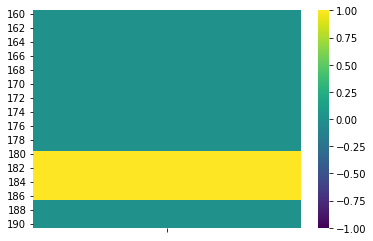

In [53]:
import seaborn as sns
sns.heatmap(pd.DataFrame(index=np.arange(len(label)), data=label.numpy().reshape(-1), columns=['']).loc[160:190], cmap='viridis', vmin=-1, vmax=1)

So the x-part is a `BatchEncoding` of the `pn_history` followed by the `feature_text`. The y-part is a token-level encoding of the `pn_history` with -1 for special tokens, 0 for non-target tokens, and 1 for tarket tokens

In [63]:
CFG.tokenizer('hello', 'world')

{'input_ids': [1, 42891, 2, 8331, 2], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [69]:
CFG.tokenizer.decode(2)

'[SEP]'

In [67]:
CFG.tokenizer('hello world')

{'input_ids': [1, 42891, 232, 2], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [59]:
type(CFG.tokenizer)

transformers.models.deberta.tokenization_deberta_fast.DebertaTokenizerFast

The thing we are seeing with the Ġworld seems to be a `prefix space` and detailed [here](https://discuss.huggingface.co/t/bpe-tokenizers-and-spaces-before-words/475). 

# Are we overwriting the existing embeddings of the model?

In [70]:
model = CustomModel(CFG, config_path=None, pretrained=True)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Nope! We were just applying weight initialization to the fully connected layer

# My Data Cleaning Based on Theo Veil's

We want to make sure that all the data is in a consistent format, but I don't think as part of this step of data cleaning we should apply tokenization as that is model-specific. Abstractly, the goal is going to be to have the following for each labeled instance:

- The pn_history as a string with any mistakes that would throw off tokenizers removed
- The feature text as a string with any mistakes that would throw off tokenizers removed
- The annotations as a list of (S, E) pairs which have the property that `pn_history[S:E]` is relevant to the feature text

In [178]:
from project.data.data_loaders import get_features, get_patient_notes, get_train
train, features, patient_notes = get_train(), get_features(), get_patient_notes()

In [179]:
features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago" # This feature is incorrectly coded as 'Last-Pap-smear-I-year-ago'
train = train.merge(features, on=['feature_num', 'case_num'], how='left').merge(patient_notes, on=['pn_num', 'case_num'], how='left')

In [180]:
# Corrections taken from https://www.kaggle.com/code/naveace/nbme-deberta-base-baseline-train/edit
for idx, correction_dict in json.load(open('annotation_corrections.json', 'r')).items():
    idx = int(idx)
    train.loc[idx, 'annotation'] = correction_dict['correct annotation']
    train.loc[idx, 'location'] = correction_dict['correct location']

In location, every entry is a list. For all strings in the list, they are either of the form `'s e'` or `'s e;s e;...'`

In [181]:
train['annotation'] = train['annotation'].map(eval)
train['location'] = train['location'].map(eval)

In [182]:
from functools import reduce
def get_start_and_end_indices(locations: str) -> List[Tuple[int, int]]:
    """
    Maps strings of the form '\d+ \d+(;\d+ \d+)*' to a list of tuples of the form (start, end).
    E.g. '1 2' -> [(1, 2)]
         '1 2;3 4' -> [(1, 2), (3, 4)]
         '' -> []
    """
    assert(isinstance(locations, str))
    if locations == '':
        return []
    if not ';' in locations:
        s, e = locations.split()
        return [(int(s), int(e))]
    return list(map(lambda s: get_start_and_end_indices(s)[0], locations.split(';')))
def convert_to_idx_tuple_pairs(location_list: List[str]) -> List[Tuple[int, int]]:
    """
    Maps a list of strings of the form '\d+ \d+(;\d+ \d+)*' to a list of tuples of the form (start, end).
    E.g. ['1 2', '3 4'] -> [(1, 2), (3, 4)]
    """
    return list(reduce(lambda l1, l2: l1 + l2, map(get_start_and_end_indices, location_list), []))

In [184]:
train['location_idx_tuple_pairs'] = train['location'].map(convert_to_idx_tuple_pairs)

In [186]:
def assert_correctness(labels):
    """
    Asserts correct types for labels
    """
    for idx, element in enumerate(labels):
        try:
            assert(isinstance(element, list))
            for obj in element:
                assert(isinstance(obj, tuple))
                assert(len(obj) == 2)
                assert(isinstance(obj[0], int))
                assert(isinstance(obj[1], int))
        except AssertionError:
            print(f'Failed assertion for element {idx}: {element}')
        
assert_correctness(train['location_idx_tuple_pairs'])

## Wrapping it all up into one data cleaning function

In [193]:
from functools import reduce
def get_start_and_end_indices(locations: str) -> List[Tuple[int, int]]:
    """
    Maps strings of the form '\d+ \d+(;\d+ \d+)*' to a list of tuples of the form (start, end).
    E.g. '1 2' -> [(1, 2)]
         '1 2;3 4' -> [(1, 2), (3, 4)]
         '' -> []
    """
    assert(isinstance(locations, str))
    if locations == '':
        return []
    if not ';' in locations:
        s, e = locations.split()
        return [(int(s), int(e))]
    return list(map(lambda s: get_start_and_end_indices(s)[0], locations.split(';')))
def convert_to_idx_tuple_pairs(location_list: List[str]) -> List[Tuple[int, int]]:
    """
    Maps a list of strings of the form '\d+ \d+(;\d+ \d+)*' to a list of tuples of the form (start, end).
    E.g. ['1 2', '3 4'] -> [(1, 2), (3, 4)]
    """
    return list(reduce(lambda l1, l2: l1 + l2, map(get_start_and_end_indices, location_list), []))
def assert_correctness(labels) -> None:
    """
    Asserts correct types for labels
    """
    for idx, element in enumerate(labels):
        try:
            assert(isinstance(element, list))
            for obj in element:
                assert(isinstance(obj, tuple))
                assert(len(obj) == 2)
                assert(isinstance(obj[0], int))
                assert(isinstance(obj[1], int))
        except AssertionError:
            print(f'Failed assertion for element {idx}: {element}')

def get_clean_train_data() -> pd.DataFrame:
    """
    Produces a cleaned version of the train dataframe with the following:
    id: a unique id for the train instance (as in Kaggle)
    case_num: unique id for case (as in Kaggle)
    pn_num: unique id for patient note (as in Kaggle)
    feature_num: unique id for patient note (as in kaggle)
    annotation: a List[str] of the text in patient note pn_num that corresponds to feature pn_num. 
        Each element is not necessarily contiguous but is human-readable. Some elements may splice together parts of patient note
    location_raw: the raw location (as in Kaggle)
    feature_text: the feature text for the feature feature_num (as in Kaggle)
    pn_history: the patient note (as in Kaggle)
    location: a List[Tuple[start: int, end: int]] of the ranges of characters in the patient note that corresponds to the feature (positives)
    """
    train, features, patient_notes = get_train(), get_features(), get_patient_notes()
    features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago" # This feature is incorrectly coded as 'Last-Pap-smear-I-year-ago'
    train = train.merge(features, on=['feature_num', 'case_num'], how='left').merge(patient_notes, on=['pn_num', 'case_num'], how='left')
    # Corrections taken from https://www.kaggle.com/code/naveace/nbme-deberta-base-baseline-train/edit
    for idx, correction_dict in json.load(open('annotation_corrections.json', 'r')).items():
        idx = int(idx)
        train.loc[idx, 'annotation'] = correction_dict['correct annotation']
        train.loc[idx, 'location'] = correction_dict['correct location']
    # Creating cleaned `location` column
    train['annotation'] = train['annotation'].map(eval)
    train['location'] = train['location'].map(eval)
    train['location_idx_tuple_pairs'] = train['location'].map(convert_to_idx_tuple_pairs)
    assert_correctness(train['location_idx_tuple_pairs'])
    train = train.rename(columns={'location': 'location_raw', 'location_idx_tuple_pairs': 'location'})
    return train

In [ ]:
# For reference only, this is the code use to make cleaning script
annotation_correction_code = \
"""
# incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')
"""

In [ ]:
# For reference only, this is the cleaning script
import re
from typing import Dict
corrections:Dict[str, Dict[str, str]] = {}
for idx, correct_string in re.findall(r"train.loc\[([0-9]+), 'annotation'][ ]*=[ ]*ast.literal_eval\('(.*)'\)", annotation_correction_code, re.MULTILINE):
    result_list = eval(correct_string)  # He doubly nested corrections to match his format in create_labels_for_scoring
    result_list = [l[0] for l in result_list]
    corrections[idx] = {'correct annotation': str(result_list)} # Cast to string to be consistent with other data and avoid special cases
for idx, correct_location in re.findall(r"train.loc\[([0-9]+), 'location'][ ]*=[ ]*ast.literal_eval\('(.*)'\)", annotation_correction_code, re.MULTILINE):
    result_list = eval(correct_location)
    result_list = [l[0] for l in result_list]
    corrections[idx].update({'correct location': str(result_list)})  # Cast to string to be consistent with other data and avoid special cases
json.dump(corrections, open('annotation_corrections.json', 'w'))


## Evaluation of function

In [194]:
from project.data.data_loaders import get_clean_train_data
train = get_clean_train_data()

In [195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14300 entries, 0 to 14299
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            14300 non-null  object
 1   case_num      14300 non-null  int64 
 2   pn_num        14300 non-null  int64 
 3   feature_num   14300 non-null  int64 
 4   annotation    14300 non-null  object
 5   location_raw  14300 non-null  object
 6   feature_text  14300 non-null  object
 7   pn_history    14300 non-null  object
 8   location      14300 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


In [198]:
for idx, row in train.sample(10).iterrows():
    print(f'***Feature: {row["feature_text"]}')
    print(f'***Patient note: {row["pn_history"]}')
    print('***Identified locations:')
    if len(row['location']) == 0:
        print('\t None')
    for (s, e) in row['location']:
        print(f'\t{row["pn_history"][s:e]}')


***Feature: Worse-with-deep-breath-OR-pleuritic
***Patient note: 17y/o male c/o chest pain
he woke up with the chest pain yesterday monining, it is a sharp pain that is every time when he brathes in. denies trauma. no radiation of pain. Took tylonol several times, helped a little. 
(-) sick contacts, cough. 
(+) muscle aches, 
NKDA. Exercise induced-asthma. Takes albuterol inhaler . 
Father: asthma, high cholesterol, Mother: no known diseases. 
Climber, lives with parents and sister and brother. 
(-) smoking. drinks beers on parties. 

***Identified locations:
	 None
***Feature: Irregular-flow-OR-Irregular-frequency-OR-Irregular-intervals
***Patient note: The patient is a 44 year old female who presents with irregular periods. Her last period was 2 months ago. Over the past 3 years her periods have been "unpredictable," with various amounts of bleeding and frequency of menstrual cycles. She also endorses vaginal dryness, discomfort with intercourse, hot flashes, and nausea and vomiting

In [189]:
train.columns

Index(['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location_raw',
       'feature_text', 'pn_history', 'location'],
      dtype='object')

# Creation of a classifier for Myalgias

In [2]:
from project.data.data_loaders import get_clean_train_data
import pandas as pd
import numpy as np
import sentence_transformers
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import classification_report

In [3]:
train = get_clean_train_data()
myalglias_data = train.query('feature_text == "Myalgias"')  # Manual inspection of features.csv shows this is the only way the feature comes up
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14300 entries, 0 to 14299
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            14300 non-null  object
 1   case_num      14300 non-null  int64 
 2   pn_num        14300 non-null  int64 
 3   feature_num   14300 non-null  int64 
 4   annotation    14300 non-null  object
 5   location_raw  14300 non-null  object
 6   feature_text  14300 non-null  object
 7   pn_history    14300 non-null  object
 8   location      14300 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.6+ MB
None


We can split our data into three types

1. Those where we would not expect Myalgias to be present
2. Those where we would expect it to be present but it is not
3. Those where we would expect it to be present and it is

The difference between types 2 and 3 is more important than the difference between types 1 and 3, since it requires more fine grain skills. Similiarly the difference between 1 and 2 is moreimportant than the difference between 1 and 3 since it precludes just predicting Myalgias if we see the general context of the partient. 


In [4]:
for _, df in train.copy().groupby('pn_num'):
    SHOULD_HAVE_MYALGIAS = 'Myalgias' in  df['feature_text'].unique()
    DOES_HAVE_MYALGIAS = False 
    if SHOULD_HAVE_MYALGIAS and len(df.query('feature_text == "Myalgias"')['location'].iloc[0]) > 0:
        DOES_HAVE_MYALGIAS = True
    train.loc[df.index, 'should_have_myalgias'] = SHOULD_HAVE_MYALGIAS
    train.loc[df.index, 'does_have_myalgias'] = DOES_HAVE_MYALGIAS

In [5]:
print(train.query('feature_text == "Myalgias"')[['location', 'should_have_myalgias', 'does_have_myalgias']])
print(train.query('feature_text != "Myalgias"')[['should_have_myalgias', 'does_have_myalgias']])

           location should_have_myalgias does_have_myalgias
12603            []                 True              False
12620            []                 True              False
12637  [(370, 378)]                 True               True
12654            []                 True              False
12671  [(378, 388)]                 True               True
...             ...                  ...                ...
14218            []                 True              False
14235            []                 True              False
14252            []                 True              False
14269            []                 True              False
14286            []                 True              False

[100 rows x 3 columns]
      should_have_myalgias does_have_myalgias
0                    False              False
1                    False              False
2                    False              False
3                    False              False
4                    False

In [6]:
def get_label(row: pd.Series):
    if not row['should_have_myalgias']:
        return -1
    elif not row['does_have_myalgias']:
        return 0
    else:
        return 1
train['label'] = train.apply(get_label, axis=1)

At this point, all that matters is unique patient ids

In [7]:
train = train.drop_duplicates(subset=['pn_num']).reset_index(drop=True)[['pn_num', 'pn_history', 'label']]
train.head()

,pn_num,pn_history,label
0,16,HPI: 17yo M presents with palpitations. Patien...,-1
1,41,17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,-1
2,46,Mr. Cleveland is a 17yo M who was consented by...,-1
3,82,17 yo M w/ no cardiac or arrhythmia PMH presen...,-1
4,100,HPI: Dillon Cleveland is an otherwise healthy ...,-1


In [8]:
train.label.value_counts()

-1    900
 0     71
 1     29
Name: label, dtype: int64

In [9]:
train.columns

Index(['pn_num', 'pn_history', 'label'], dtype='object')

In [10]:
from project.embedding.embedding_mechanism import CorpusEmbedder
train['embedding'] = [CorpusEmbedder('all-mpnet-base-v2').embed(row[['pn_num', 'pn_history']]) for _, row in train.iterrows()]

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
N_FOLDS = 2
for _, df in train.copy().groupby('label'):
    splits = [test_idx for (train_idx, test_idx) in KFold(n_splits=N_FOLDS, shuffle=True, random_state=42).split(df)]
    for fold, split_idx in enumerate(splits):
        train.loc[df.iloc[split_idx].index, 'fold'] = fold

In [14]:
for fold in range(N_FOLDS):
    fold_train = train.query('fold != @fold').query('label != -1')
    fold_test = train.query('fold == @fold').query('label != -1')
    X_train = np.stack(fold_train['embedding'].values)
    X_test = np.stack(fold_test['embedding'].values)
    y_train = fold_train['label'].values
    y_test = fold_test['label'].values
    model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

[17:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.44      0.27      0.33        15

    accuracy                           0.69        51
   macro avg       0.59      0.56      0.56        51
weighted avg       0.65      0.69      0.66        51

[17:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       

/Users/evanvogelbaum/opt/anaconda3/envs/PersonalCoding/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/evanvogelbaum/opt/anaconda3/envs/PersonalCoding/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [19]:
get_clean_train_data().groupby('feature_text').count().value_counts()

id   case_num  pn_num  feature_num  annotation  location_raw  pn_history  location
100  100       100     100          100         100           100         100         125
200  200       200     200          200         200           200         200           4
300  300       300     300          300         300           300         300           1
700  700       700     700          700         700           700         700           1
dtype: int64